In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%matplotlib inline

In [2]:
# load dataset
df_JFC = pd.read_csv('./datasets/JFC_2yrs.csv', header=0, index_col=0)
df_JFC.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
06/17/2021,202.0,206.2,211.0,200.0,755.47K,-2.32%
06/18/2021,200.6,202.0,206.0,200.0,894.59K,-0.69%
06/21/2021,202.2,200.0,205.0,197.8,652.82K,0.80%
06/22/2021,206.4,202.2,209.0,201.6,647.71K,2.08%
06/23/2021,210.4,208.4,212.0,208.4,453.39K,1.94%


<class 'pandas.core.frame.DataFrame'>
Index: 493 entries, 06/17/2021 to 06/15/2023
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     493 non-null    float64
 1   Open      493 non-null    float64
 2   High      493 non-null    float64
 3   Low       493 non-null    float64
 4   Vol.      493 non-null    object 
 5   Change %  493 non-null    object 
dtypes: float64(4), object(2)
memory usage: 27.0+ KB


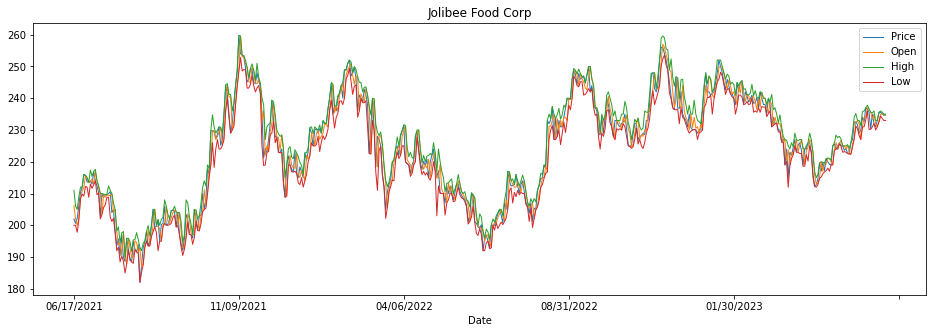

In [3]:
df_JFC.info()
df_JFC.plot(figsize=(16,5),lw=1, title="Jolibee Food Corp")
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

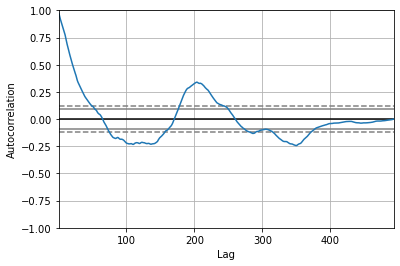

In [4]:
autocorrelation_plot(df_JFC[["Open","High","Low","Price"]])

### Choosing Close Columns for model predictions

<class 'pandas.core.series.Series'>
Index: 493 entries, 06/17/2021 to 06/15/2023
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
493 non-null    float64
dtypes: float64(1)
memory usage: 7.7+ KB


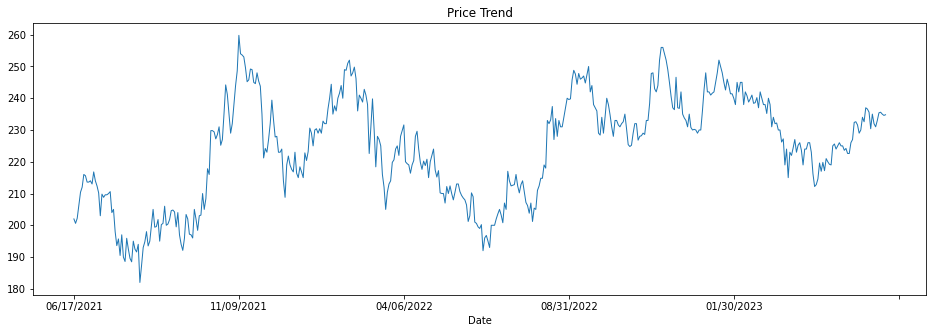

In [5]:
df_close = df_JFC["Price"]
df_close.info()
df_close.plot(figsize=(16,5),lw=1, title="Price Trend")
plt.show()

### Split data for train and test

In [6]:
# Split the data for train and test
df_train = df_close[:473].copy()
df_test = df_close[473:].copy()

In [7]:
# Creating function to display ACF anf PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=30)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

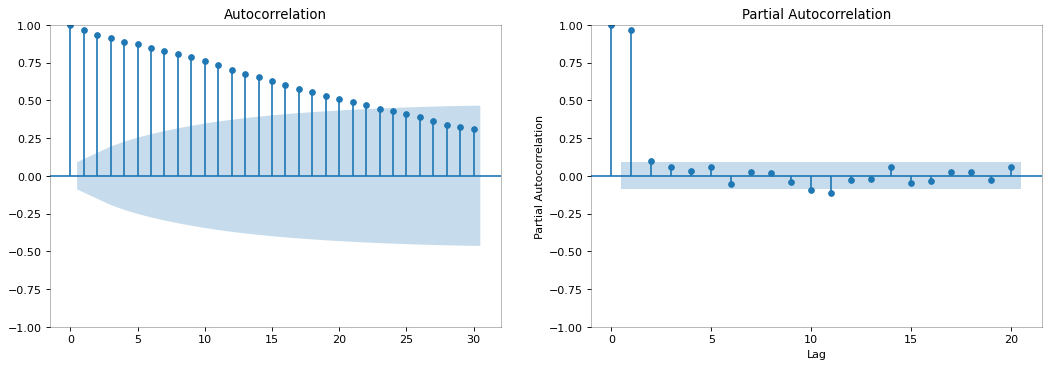

In [8]:
plot_correlation(df_train)

### Get p-value with ADF and KPSS test

In [9]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [10]:
ADF(df_train)

Column Name: Close Variable
ADF Statistic: -2.756747
p-value: 0.064723
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [11]:
# KPSS Test 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [12]:
kpss_test(df_train.values)

Results of KPSS Test:
Test Statistic            0.906213
p-value                   0.010000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Transform to stationary

p.value: -2.80000000000004


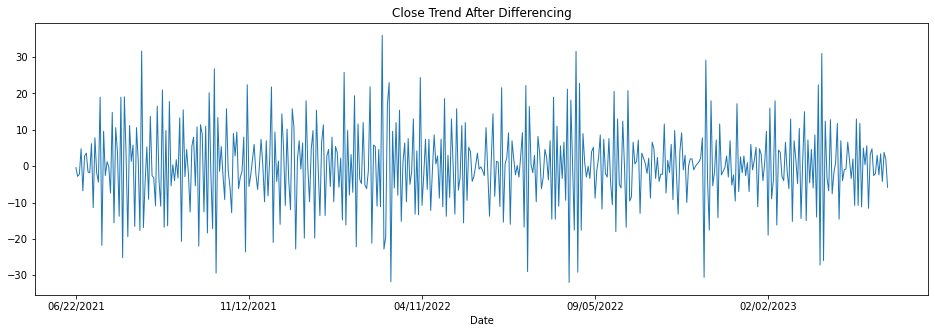

In [15]:
# Perform differencing
df_train_diff = df_train.diff().diff().diff().dropna()
df_train_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")
print(f"p.value: {df_train_diff[1]}" )
plt.show()

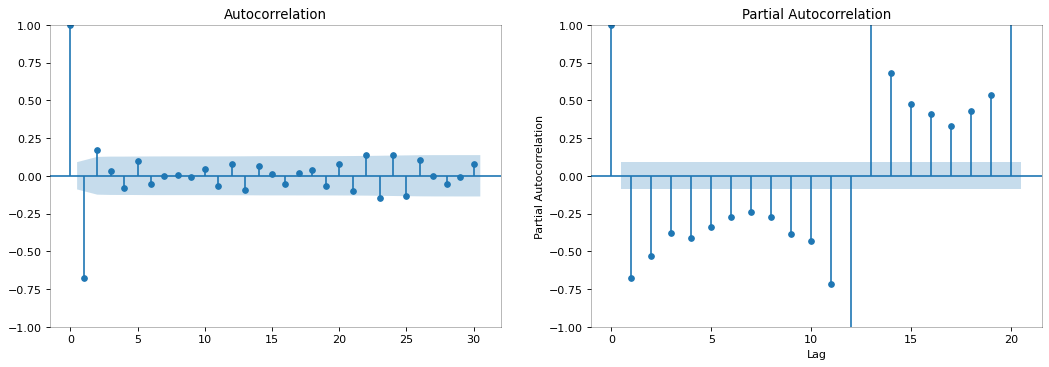

In [16]:
plot_correlation(df_train_diff)

## Determine model parameters p, q

In [17]:
# library that determine best parameters for ARIMA model
import pmdarima as pm
from pmdarima import auto_arima

In [18]:
model = auto_arima(df_train, start_p=0, start_q=0,
                          max_p=2, max_q=2,m=12,start_P=0,start_Q=0, 
                          max_P = 2, max_Q = 2,
                          seasonal=True,
                          d=3,D=3,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,3,0)[12]             : AIC=4530.890, Time=0.48 sec
 ARIMA(1,3,0)(1,3,0)[12]             : AIC=3724.740, Time=2.57 sec
 ARIMA(0,3,1)(0,3,1)[12]             : AIC=inf, Time=3.82 sec
 ARIMA(1,3,0)(0,3,0)[12]             : AIC=4269.732, Time=0.88 sec
 ARIMA(1,3,0)(2,3,0)[12]             : AIC=3678.519, Time=6.88 sec
 ARIMA(1,3,0)(2,3,1)[12]             : AIC=inf, Time=16.07 sec
 ARIMA(1,3,0)(1,3,1)[12]             : AIC=inf, Time=7.95 sec
 ARIMA(0,3,0)(2,3,0)[12]             : AIC=3917.545, Time=3.03 sec
 ARIMA(2,3,0)(2,3,0)[12]             : AIC=3551.569, Time=8.07 sec
 ARIMA(2,3,0)(1,3,0)[12]             : AIC=3609.520, Time=3.78 sec
 ARIMA(2,3,0)(2,3,1)[12]             : AIC=inf, Time=20.60 sec
 ARIMA(2,3,0)(1,3,1)[12]             : AIC=inf, Time=10.22 sec
 ARIMA(2,3,1)(2,3,0)[12]             : AIC=inf, Time=23.73 sec
 ARIMA(1,3,1)(2,3,0)[12]             : AIC=inf, Time=18.08 sec
 ARIMA(2,3,0)(2,3,0)[12] intercept   : AIC=3553.5

## Fit the ARIMA Model

In [19]:
model = ARIMA(df_train, order=(2,3,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  473
Model:                 ARIMA(2, 3, 0)   Log Likelihood               -1585.629
Date:                Fri, 16 Jun 2023   AIC                           3177.258
Time:                        15:27:36   BIC                           3189.716
Sample:                             0   HQIC                          3182.159
                                - 473                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0313      0.037    -27.975      0.000      -1.104      -0.959
ar.L2         -0.5251      0.037    -14.336      0.000      -0.597      -0.453
sigma2        49.7396      2.671     18.625      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Make time series prediction

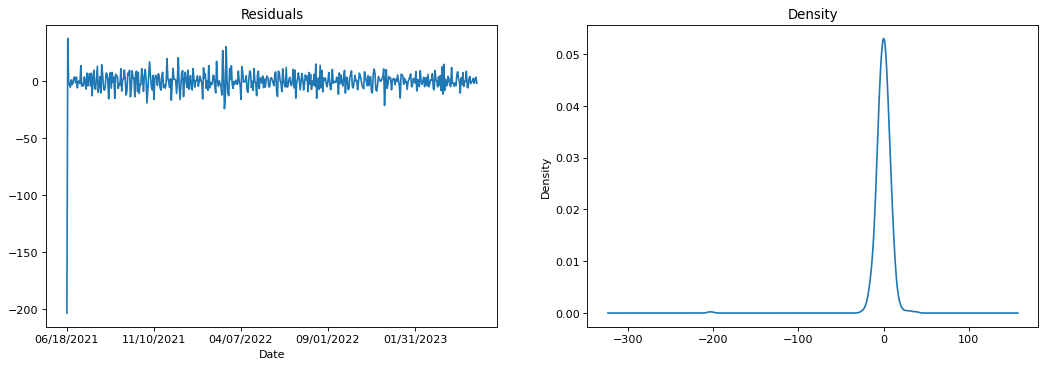

In [20]:
# Getting residuals pattern
# To make sure model capture adequate information from the data
residuals = model_fit.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(16,5), dpi=80)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

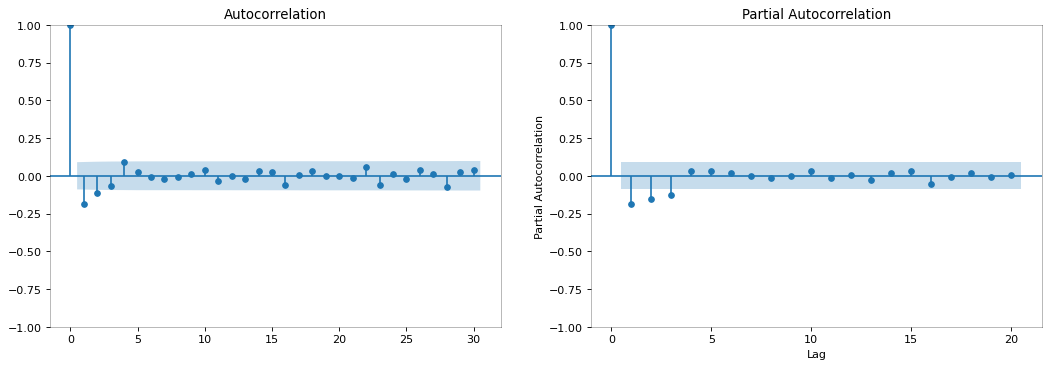

In [21]:
plot_correlation(residuals)

In [22]:
forecast = model_fit.forecast(len(df_test))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [23]:
forecast.index = df_test.index
new_df = pd.concat([forecast, df_test], axis=1)
new_df

,predicted_mean,Price
Date,,
05/18/2023,230.636187,232.4
05/19/2023,234.760611,232.6
05/22/2023,238.943743,231.6
05/23/2023,244.756508,229.0
05/24/2023,250.804401,230.0
05/25/2023,257.700603,234.0
05/26/2023,265.545052,232.6
05/29/2023,273.912684,237.0
05/30/2023,283.189378,236.6


<AxesSubplot:xlabel='Date'>

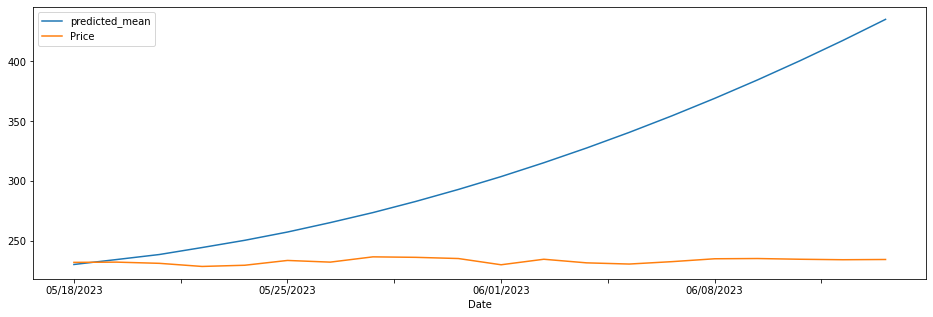

In [24]:
new_df.plot(figsize=(16,5))

## Fit the SARIMAX Model

In [25]:
train = df_close[:473].copy()
test = df_close[473:].copy()

In [26]:
final_model = SARIMAX(train,order=(2,3,0),seasonal_order=(2,3,0,12)) # Best model:  ARIMA(2,3,0)(2,3,0)[12]      
result = final_model.fit()
print(result.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43270D+00    |proj g|=  4.52867D-02

At iterate    5    f=  4.12225D+00    |proj g|=  2.49743D-01

At iterate   10    f=  3.76579D+00    |proj g|=  3.53099D-02

At iterate   15    f=  3.74376D+00    |proj g|=  2.35017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   3.458D-06   3.744D+00
  F =   3.7437305971432422     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

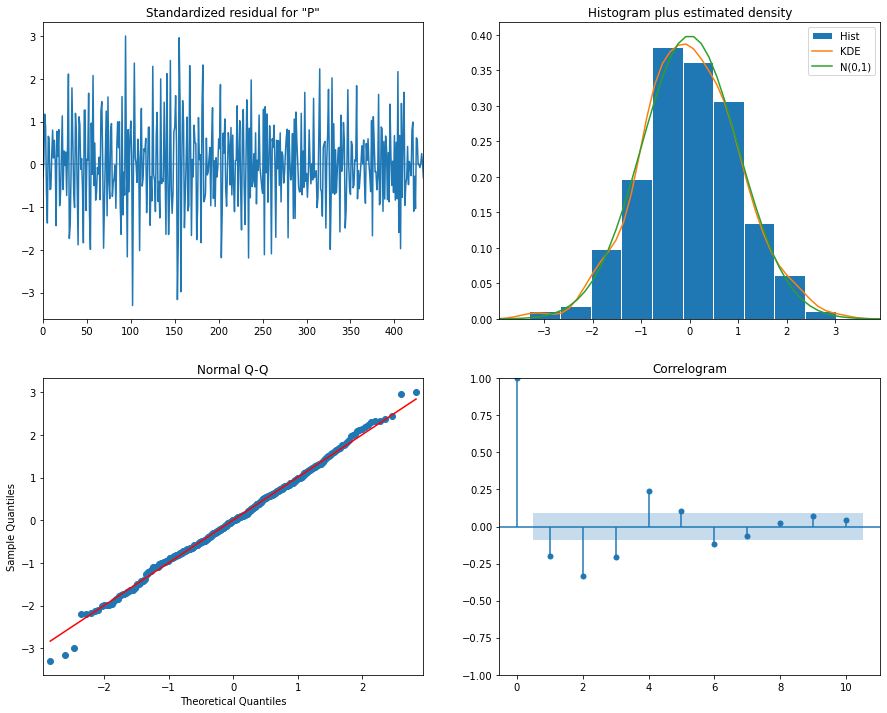

In [27]:
result.plot_diagnostics(figsize=(15, 12));

In [28]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# Best model:  ARIMA(2,3,0)(2,3,0)[12]     
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,3,0)(2,3,0,12) Predictions')# Plot predictions against known values

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [29]:
predictions.index = test.index
joined_df = pd.concat([predictions, test], axis=1)
joined_df

,"SARIMA(2,3,0)(2,3,0,12) Predictions",Price
Date,,
05/18/2023,232.746786,232.4
05/19/2023,227.095599,232.6
05/22/2023,234.973707,231.6
05/23/2023,237.351261,229.0
05/24/2023,237.946011,230.0
05/25/2023,240.768648,234.0
05/26/2023,241.300327,232.6
05/29/2023,239.484247,237.0
05/30/2023,242.604518,236.6


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Production')]

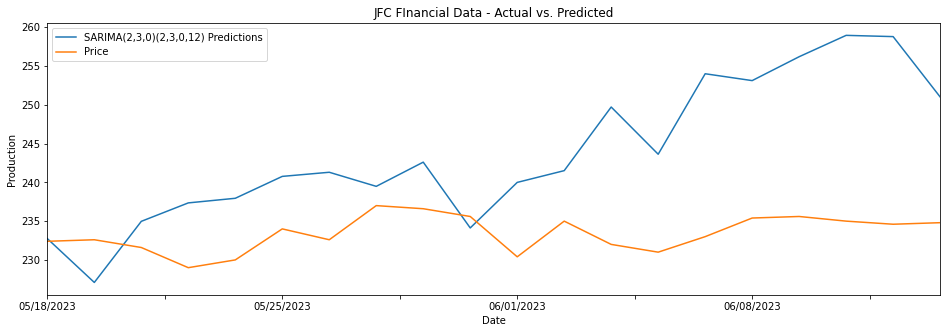

In [30]:
title = 'JFC FInancial Data - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'
ax = joined_df.plot(legend=True, figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)